In [1]:
import os, sys; sys.path.append(os.path.dirname(os.getcwd()))

In [2]:
import torch
from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt

import util.RAVDESS_dataset_util as Rd
import multimodal_vae
from train_mvae import build_model, train

from config_args import ConfigModelArgs, ConfigTrainArgs

In [3]:
cfg_model = ConfigModelArgs()
cfg_train = ConfigTrainArgs()

In [4]:
face_dataset = Rd.FaceEmotionDataset(
    root_dir=cfg_model.dataset_path,
    transform=transforms.Compose
    ([
        Rd.Rescale(cfg_model.img_size), 
        Rd.CenterCrop(cfg_model.img_size), 
        Rd.ToTensor()
    ]))

trainingset_len = len(face_dataset) // 100 * 100
testset_len = len(face_dataset) - trainingset_len
training_dataset, testing_dataset = torch.utils.data.random_split(
    face_dataset, 
    [trainingset_len, testset_len],
    #generator=torch.Generator().manual_seed(42)
)

In [5]:
model: torch.nn.Module = build_model(
    cat_dim=cfg_model.cat_dim,
    latent_space_dim=cfg_model.z_dim,
    hidden_dim=cfg_model.hidden_dim,
    loss_weights=cfg_model.loss_weights,
    expert_type=cfg_model.expert_type,
    use_cuda=True
).double()

In [6]:
training_losses = train(
    mvae_model=model,
    dataset=training_dataset,
    learning_rate=cfg_train.learning_rate,
    optim_betas=cfg_train.optim_betas,
    num_epochs=cfg_train.num_epochs,
    batch_size=cfg_train.batch_size,
    checkpoint_every=cfg_train.checkpoint_every,
    checkpoint_path=cfg_train.checkpoint_path,
    save_model=cfg_train.save_model,
    seed=cfg_train.seed,
    use_cuda=cfg_train.use_cuda,
    cfg=cfg_train
)

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [02:45<00:00,  5.34s/it]


Mean epoch loss: 10.448; Mean all modalities loss: 15.311; Mean faces loss: 2.1513; Mean emotions loss: 13.881; 


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [02:42<00:00,  5.23s/it]


Mean epoch loss: 7.0683; Mean all modalities loss: 10.586; Mean faces loss: 0.60386; Mean emotions loss: 10.015; 


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [02:42<00:00,  5.23s/it]

Mean epoch loss: 7.0991; Mean all modalities loss: 10.6; Mean faces loss: 0.47175; Mean emotions loss: 10.225; 


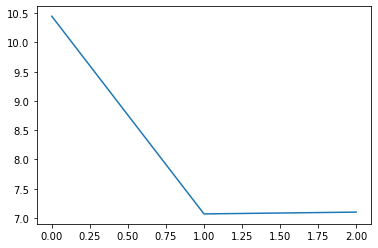

In [7]:
plt.plot(training_losses['total_loss'])

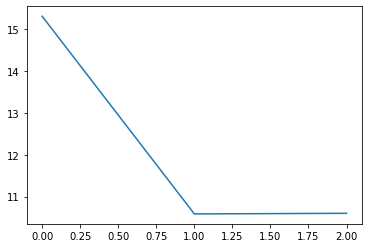

In [8]:
plt.plot(training_losses['multimodal_loss'])

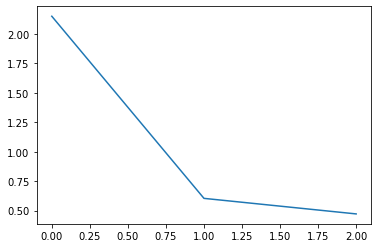

In [9]:
plt.plot(training_losses['faces_loss'])

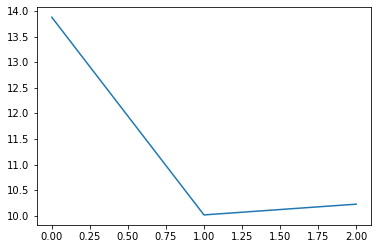

In [10]:
plt.plot(training_losses['emotions_loss'])

In [57]:
def testBatch(model, dataset_loader, img_size=64, use_cuda=True):
    input_array = np.zeros(shape=(img_size, 1, 3), dtype="uint8")
    reconstructed_array = np.zeros(shape=(img_size, 1, 3), dtype="uint8")
    
    input_emotions, reconstructed_emotions = [], []
    
    model.eval()
    
    sample = next(iter(dataset_loader))
    images = sample['image']
    labels = sample['cat']
    
    if use_cuda:
        images = images.cuda()
        labels = labels.cuda()

    #imageshow(torchvision.utils.make_grid(images))
    batch_size = images.shape[0]
    
    reconstructed_images, reconstructed_emotions, _, _ = model.forward(faces=images, emotions=labels)

    # img -> z -> img
    predicted = []
    for idx in range(batch_size):
        input_image = images[idx]
        
        # storing the input image
        input_image_display = np.array(input_image.cpu()*255., dtype='uint8').transpose((1, 2, 0))
        input_array = np.concatenate((input_array, input_image_display), axis=1)
        
        # generating the reconstructed image and adding to array
        input_image = input_image.view(1, 3, img_size, img_size)
        
        reconstructed_img = reconstructed_images[idx].cpu().view(3, img_size, img_size).detach().numpy()
        reconstructed_img = np.array(reconstructed_img*255., dtype='uint8').transpose((1, 2, 0))
        reconstructed_array = np.concatenate((reconstructed_array, reconstructed_img), axis=1)
        
    # remove first, blank column, and concatenate
    input_array = input_array[:,1:,:]
    reconstructed_array = reconstructed_array[:,1:,:]
    display_array = np.concatenate((input_array, reconstructed_array), axis=0)
    plt.imshow(display_array)

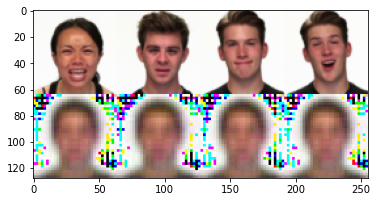

In [58]:
from torch.utils.data import DataLoader

dataset_loader = DataLoader(training_dataset, batch_size=4,
                        shuffle=True, num_workers=7)

testBatch(model, dataset_loader)

In [ ]:
print()